In [1]:
import numpy as np

# Load the original data
loaded_data = np.load('E_field_data_combined_extended.npz', allow_pickle=True)
E_data_combined = loaded_data['data']

# Define the full set of angles
all_angles = {0, 30, 60, 90}

# Define filter sets for training (leave-one-out approach)
filter_sets = [
    {30, 60, 90},  # Training: {30, 60, 90} → Testing: {0}
    {0, 60, 90},   # Training: {0, 60, 90} → Testing: {30}
    {0, 30, 90},   # Training: {0, 30, 90} → Testing: {60}
    {0, 30, 60}    # Training: {0, 30, 60} → Testing: {90}
]

# Iterate through each filter set
for idx, train_angles in enumerate(filter_sets):
    test_angles = all_angles - train_angles  # Find the test angle (only one value)

    train_data = []
    test_data = []

    # Filter the dataset
    for i in E_data_combined:
        j, k, l = i[:3]  # Extract first three values (j, k, l)
        if j in train_angles:
            train_data.append(i)
        elif j in test_angles:
            test_data.append(i)

    # Convert lists to NumPy arrays
    train_data = np.array(train_data)
    test_data = np.array(test_data)

    # Save train and test datasets
    filename_train = f"E_field_data_filtered_{idx+1}.npz"
    filename_test = f"E_field_data_filtered_test_{idx+1}.npz"

    np.savez(filename_train, data=train_data)
    np.savez(filename_test, data=test_data)

    print(f"Saved {filename_train} with {len(train_data)} records (Train angles: {train_angles})")
    print(f"Saved {filename_test} with {len(test_data)} records (Test angle: {test_angles})")


Saved E_field_data_filtered_1.npz with 6708 records (Train angles: {90, 60, 30})
Saved E_field_data_filtered_test_1.npz with 2236 records (Test angle: {0})
Saved E_field_data_filtered_2.npz with 6708 records (Train angles: {0, 90, 60})
Saved E_field_data_filtered_test_2.npz with 2236 records (Test angle: {30})
Saved E_field_data_filtered_3.npz with 6708 records (Train angles: {0, 90, 30})
Saved E_field_data_filtered_test_3.npz with 2236 records (Test angle: {60})
Saved E_field_data_filtered_4.npz with 6708 records (Train angles: {0, 60, 30})
Saved E_field_data_filtered_test_4.npz with 2236 records (Test angle: {90})


In [2]:
import numpy as np

# Number of datasets
num_datasets = 4  

# Iterate through each dataset
for idx in range(1, num_datasets + 1):
    train_file = f"E_field_data_filtered_{idx}.npz"
    test_file = f"E_field_data_filtered_test_{idx}.npz"

    # Load training and testing data
    train_data = np.load(train_file, allow_pickle=True)['data']
    test_data = np.load(test_file, allow_pickle=True)['data']

    # Extract features (conditions) and target (matrices)
    X_train = train_data[:, :-1].astype(np.float32)
    y_train = np.array([np.array(matrix, dtype=np.float32) for matrix in train_data[:, -1]])
    y_train = y_train[:, 2:99, 2:179]  # Extract the required submatrix

    X_test = test_data[:, :-1].astype(np.float32)
    y_test = np.array([np.array(matrix, dtype=np.float32) for matrix in test_data[:, -1]])
    y_test = y_test[:, 2:99, 2:179]

    # Print shapes for verification
    print(f"Dataset {idx}:")
    print(f"  X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
    print(f"  X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")
    print("-" * 40)


Dataset 1:
  X_train Shape: (6708, 4), y_train Shape: (6708, 97, 177)
  X_test Shape: (2236, 4), y_test Shape: (2236, 97, 177)
----------------------------------------
Dataset 2:
  X_train Shape: (6708, 4), y_train Shape: (6708, 97, 177)
  X_test Shape: (2236, 4), y_test Shape: (2236, 97, 177)
----------------------------------------
Dataset 3:
  X_train Shape: (6708, 4), y_train Shape: (6708, 97, 177)
  X_test Shape: (2236, 4), y_test Shape: (2236, 97, 177)
----------------------------------------
Dataset 4:
  X_train Shape: (6708, 4), y_train Shape: (6708, 97, 177)
  X_test Shape: (2236, 4), y_test Shape: (2236, 97, 177)
----------------------------------------


this is Update version with sol

In [3]:
import numpy as np

def load_and_preprocess_data(train_file, test_file, samples_per_range=86, train_ratio=0.9):
    """
    Loads and preprocesses the dataset, including train-validation split and normalization.

    Parameters:
    - train_file (str): Path to the training data file (.npz).
    - test_file (str): Path to the test data file (.npz).
    - samples_per_range (int): Number of samples per range.
    - train_ratio (float): Proportion of data used for training (default 90%).

    Returns:
    - X_train, y_train (normalized)
    - X_val, y_val (normalized)
    - X_test, y_test (normalized)
    """
    
    # Load the training and test data
    train_data = np.load(train_file, allow_pickle=True)['data']
    test_data = np.load(test_file, allow_pickle=True)['data']
    
    total_samples = train_data.shape[0]
    num_ranges = total_samples // samples_per_range

    # Shuffle and split training-validation data
    all_ranges = np.arange(num_ranges)
    np.random.shuffle(all_ranges)
    
    train_ranges = all_ranges[:int(train_ratio * num_ranges)]
    val_ranges = all_ranges[int(train_ratio * num_ranges):]  # Remaining for validation
    print("train_ranges :" , train_ranges)
    print("val_ranges :", val_ranges)

    def get_indices_from_ranges(ranges, samples_per_range):
        indices = []
        for r in ranges:
            start = r * samples_per_range
            end = start + samples_per_range
            indices.extend(range(start, end))
        return indices

    # Get indices for train and validation sets
    train_indices = get_indices_from_ranges(train_ranges, samples_per_range)
    val_indices = get_indices_from_ranges(val_ranges, samples_per_range)
    
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    # Extract features (X) and target (y)
    X_full = train_data[:, :-1].astype(np.float32)
    y_full = np.array([np.array(matrix, dtype=np.float32) for matrix in train_data[:, -1]])
    y_full = y_full[:, 2:99, 2:179]  # Extract submatrix

    # Train-Validation Split
    X_train, X_val = X_full[train_indices], X_full[val_indices]
    y_train, y_val = y_full[train_indices], y_full[val_indices]

    # Load test data
    X_test = test_data[:, :-1].astype(np.float32)
    y_test = np.array([np.array(matrix, dtype=np.float32) for matrix in test_data[:, -1]])
    y_test = y_test[:, 2:99, 2:179]

    # **Normalization Using Min-Max Scaling**
    y_min = y_train.min()
    y_max = y_train.max()

    y_train = (y_train - y_min) / (y_max - y_min)
    y_val = (y_val - y_min) / (y_max - y_min)
    y_test = (y_test - y_min) / (y_max - y_min)  # Normalize using y_train's min-max

    # Print shapes and min-max values for verification
    print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
    print(f"X_val Shape: {X_val.shape}, y_val Shape: {y_val.shape}")
    print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")
    print(f"y_train min: {y_train.min()}, max: {y_train.max()}")
    print(f"y_val min: {y_val.min()}, max: {y_val.max()}")
    print(f"y_test min: {y_test.min()}, max: {y_test.max()}")

    return X_train, y_train, X_val, y_val, X_test, y_test

# Example Usage:
train_file = "E_field_data_filtered_1.npz"
test_file = "E_field_data_filtered_test_1.npz"

X_train, y_train, X_val, y_val, X_test, y_test = load_and_preprocess_data(train_file, test_file)


train_ranges : [44 66 53 48 11  1  9 31 69 59 10  6 77 42 38 72 56 55 13 73 12  8 70 30
 60 36 15 25 46 14 26 54 21 23  5 39 75 62  2 27 68 45 52 35 32 37 58 16
 71 33 50 51 65 29 67 22 49 34 47 20 61 57 19 43 63  4 41 18 17 28]
val_ranges : [76  7 74 40 24  0  3 64]
X_train Shape: (6020, 4), y_train Shape: (6020, 97, 177)
X_val Shape: (688, 4), y_val Shape: (688, 97, 177)
X_test Shape: (2236, 4), y_test Shape: (2236, 97, 177)
y_train min: 0.0, max: 1.0
y_val min: 0.05261126160621643, max: 0.9624142646789551
y_test min: 0.16905874013900757, max: 0.9943581223487854


## Now , we are update the code and use the the check point and droupout and earily stopping  

plot the best_model.h5 

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Model Architecture
def model_architecture():
    alpha = 0.0  # Leaky ReLU parameter

    def dense_block(input, num_units):
        x = Dense(num_units)(input)
        x = LeakyReLU(alpha=alpha)(x)
        return x

    inputs = Input(shape=(4,), name='data')

    x = dense_block(inputs, 8)
    x = dense_block(x, 32)
    x = dense_block(x, 128)
    x = dense_block(x, 512)
    x = dense_block(x, 2048)
    x = dense_block(x, 8192)
    x = Dense(97 * 177, activation='sigmoid')(x)

    outputs = Reshape((97, 177, 1))(x)

    model = Model(inputs, outputs, name="fcn_conv")
    
    return model

# Function to train the model with different batch sizes
# Train model with batch size
def train_with_batch_size(batch_size, X_train, X_val, y_train, y_val, file_name):
    print(f"\nTraining on {file_name} with batch size: {batch_size}")

    # Build and compile model
    model = model_architecture()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

    # Reshape labels
    y_train_reshaped = np.expand_dims(y_train, axis=-1)
    y_val_reshaped = np.expand_dims(y_val, axis=-1)

    # Define callbacks
    checkpoint = ModelCheckpoint(f'best_model_{file_name}_batch_{batch_size}.keras', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)

    # Train model
    history = model.fit(
        X_train, y_train_reshaped,
        validation_data=(X_val, y_val_reshaped),
        epochs=1000, batch_size=batch_size, verbose=1,
        callbacks=[checkpoint, early_stopping]
    )

    return history , model

# # List of batch sizes to test
# batch_sizes = [16, 32, 64, 128, 256]


# # Dictionary to store histories
# histories = {}

# # Train the model with different batch sizes
# for batch_size in batch_sizes:
#     histories[batch_size] = train_with_batch_size(batch_size)

# # Plot loss for different batch sizes
# plt.figure(figsize=(12, 6))
# for batch_size, history in histories.items():
#     plt.plot(history.history['val_loss'], label=f'Batch {batch_size}')

# plt.title('Validation Loss Over Epochs for Different Batch Sizes')
# plt.xlabel('Epochs')
# plt.ylabel('Validation MAE (Loss)')
# plt.legend()
# plt.show()



Processing: E_field_data_filtered_1.npz with Test File: E_field_data_filtered_test_1.npz
train_ranges : [15 21 71  0 48  9 57 24 44 52  4  5 14 72 69 49 67 62 39 10 13 27 55 37
 35 56 74 42 68  6 63 28 38 59 25 11 30 75 40 33  2 23  7 12 76 22  1 70
  8 58 20 43 66 46 18 29 61 19 32 51 31 34 77 64 36 26 54 60 65 45]
val_ranges : [53 17 73 50  3 16 47 41]
X_train Shape: (6020, 4), y_train Shape: (6020, 97, 177)
X_val Shape: (688, 4), y_val Shape: (688, 97, 177)
X_test Shape: (2236, 4), y_test Shape: (2236, 97, 177)
y_train min: 0.0, max: 1.0
y_val min: 0.012222230434417725, max: 0.9295064210891724
y_test min: 0.16905874013900757, max: 0.9943581223487854
X_train shape: (6020, 4), y_train shape: (6020, 97, 177)

Training on E_field_data_filtered_1.npz with batch size: 16
Epoch 1/1000
377/377 [==============================] - ETA: 0s - loss: 0.0383
Epoch 1: val_loss improved from inf to 0.03579, saving model to best_model_E_field_data_filtered_1.npz_batch_16.keras
377/377 [==============

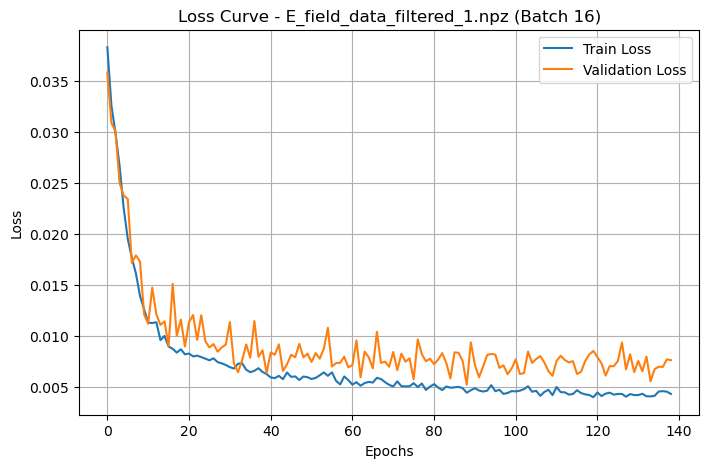

70/70 [==============================] - 1s 10ms/step - loss: 0.0476
Test Loss on E_field_data_filtered_test_1.npz (Batch 16): 0.0476
70/70 [==============================] - 1s 7ms/step
Test MAE on E_field_data_filtered_test_1.npz: 0.04762797802686691
Variance of MAE across samples: 0.006055279169231653

Processing: E_field_data_filtered_2.npz with Test File: E_field_data_filtered_test_2.npz
train_ranges : [27 52 26 43 14 56 13 49 64 23 77 74  0 66  8 36 41 12 76  6  1 37 55  5
 70 54 73 62 38 15  4 45 29 65  7 47 24 19 61 18  3 21 17 68 69 35 58 31
 72 39 59 33 34 46 67  2 42  9 25 22 30 63 75 28 16 40 48 32 20 60]
val_ranges : [50 10 57 53 71 51 11 44]
X_train Shape: (6020, 4), y_train Shape: (6020, 97, 177)
X_val Shape: (688, 4), y_val Shape: (688, 97, 177)
X_test Shape: (2236, 4), y_test Shape: (2236, 97, 177)
y_train min: 0.0, max: 1.0
y_val min: 0.007183229085057974, max: 0.9996439218521118
y_test min: 0.1583673655986786, max: 1.005673885345459
X_train shape: (6020, 4), y_train 

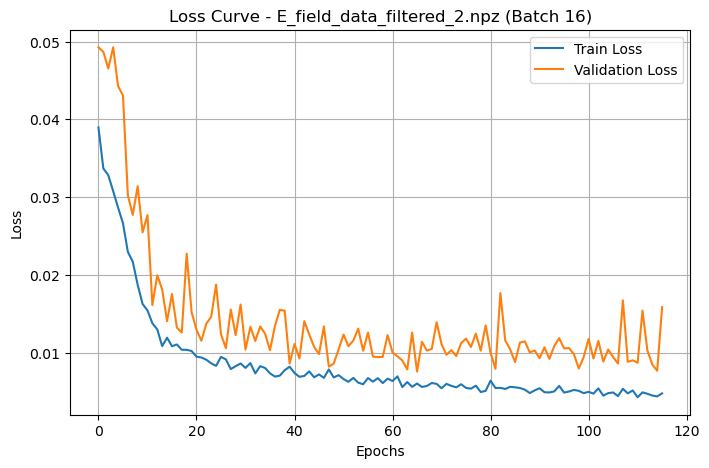

70/70 [==============================] - 1s 9ms/step - loss: 0.0399
Test Loss on E_field_data_filtered_test_2.npz (Batch 16): 0.0399
70/70 [==============================] - 0s 5ms/step
Test MAE on E_field_data_filtered_test_2.npz: 0.0398675799369812
Variance of MAE across samples: 0.0063217394053936005

Processing: E_field_data_filtered_3.npz with Test File: E_field_data_filtered_test_3.npz
train_ranges : [58 14 43 56 73 75 29 20 48 49 69 70 66  4 13 77 21 32 40  6 19 74 34 16
 54  3 51 26 52  5  8 45 22 65  9 61 68 72 64 55  1 27 24 47 23 76 30 44
 17 46 53  0 36  2 41 12 25 39 59 15 38 60 67 35 50 37 31 42 71  7]
val_ranges : [63 28 10 18 33 62 57 11]
X_train Shape: (6020, 4), y_train Shape: (6020, 97, 177)
X_val Shape: (688, 4), y_val Shape: (688, 97, 177)
X_test Shape: (2236, 4), y_test Shape: (2236, 97, 177)
y_train min: 0.0, max: 1.0
y_val min: 0.18472592532634735, max: 0.9940040707588196
y_test min: 0.07851032167673111, max: 0.9497236609458923
X_train shape: (6020, 4), y_train 

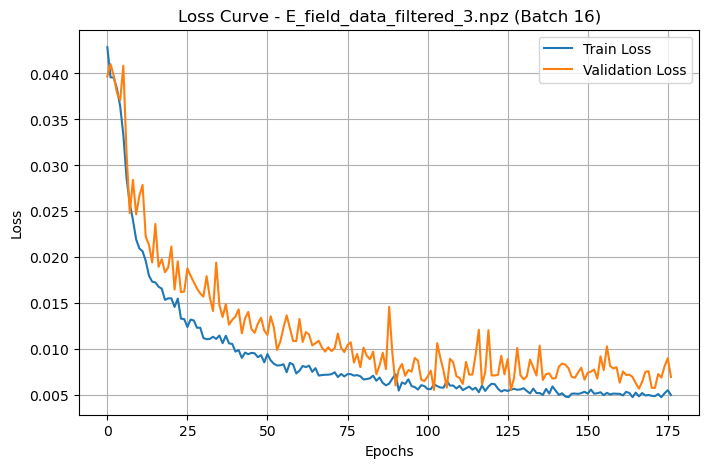

70/70 [==============================] - 0s 3ms/step - loss: 0.0393
Test Loss on E_field_data_filtered_test_3.npz (Batch 16): 0.0393
70/70 [==============================] - 0s 1ms/step
Test MAE on E_field_data_filtered_test_3.npz: 0.03928734362125397
Variance of MAE across samples: 0.004745970014482737

Processing: E_field_data_filtered_4.npz with Test File: E_field_data_filtered_test_4.npz
train_ranges : [ 0 16 62 30 25 57 51 70 74 54 75 45 61  6  7 69 34 42  4 47 22 55 73 44
 40 23 38 53 21  5 37 29 72  3 67 65 58 46 41  2 11 43 36 64 32  8 27 71
 17 60 24  9 10 18 20 66 33 19 48 35  1 12 15 50 39 59 49 63 13 77]
val_ranges : [26 14 52 76 68 28 56 31]
X_train Shape: (6020, 4), y_train Shape: (6020, 97, 177)
X_val Shape: (688, 4), y_val Shape: (688, 97, 177)
X_test Shape: (2236, 4), y_test Shape: (2236, 97, 177)
y_train min: 0.0, max: 1.0
y_val min: 0.06818092614412308, max: 0.9676369428634644
y_test min: -0.08519934862852097, max: 0.8552859425544739
X_train shape: (6020, 4), y_train

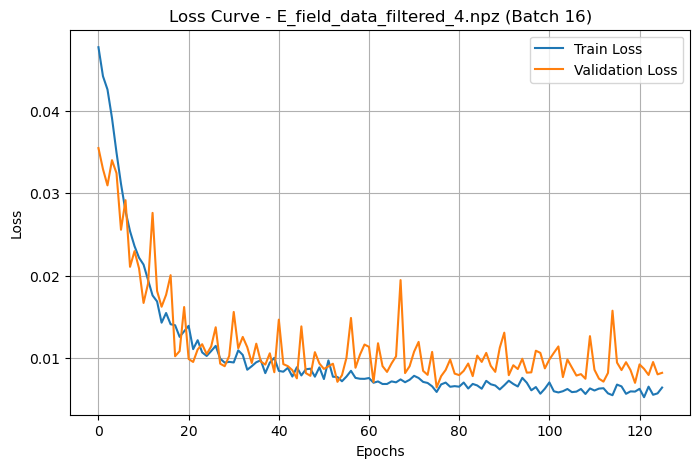

70/70 [==============================] - 0s 2ms/step - loss: 0.0170
Test Loss on E_field_data_filtered_test_4.npz (Batch 16): 0.0170
70/70 [==============================] - 0s 1ms/step
Test MAE on E_field_data_filtered_test_4.npz: 0.016954533755779266
Variance of MAE across samples: 0.001697450876235962


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# List of training and test files
train_files = [
    "E_field_data_filtered_1.npz",
    "E_field_data_filtered_2.npz",
    "E_field_data_filtered_3.npz",
    "E_field_data_filtered_4.npz"
]

test_files = [
    "E_field_data_filtered_test_1.npz",
    "E_field_data_filtered_test_2.npz",
    "E_field_data_filtered_test_3.npz",
    "E_field_data_filtered_test_4.npz"
]

# Different batch sizes to experiment with
batch_sizes = [16]

# Train on each file
for train_file, test_file in zip(train_files, test_files):
    print(f"\nProcessing: {train_file} with Test File: {test_file}")
    
    # Load and preprocess data
    X_train, y_train, X_val, y_val, X_test, y_test = load_and_preprocess_data(train_file, test_file)
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    
    for batch_size in batch_sizes:
        # Train and get history
        history, model = train_with_batch_size(batch_size, X_train, X_val, y_train, y_val , train_file)

        # Save the trained model
        model_filename = f"best_model_{train_file}_batch_{batch_size}.keras"
        model.save(model_filename)
        print(f"Model saved as: {model_filename}")

        # Plot the loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Loss Curve - {train_file} (Batch {batch_size})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()

        # Evaluate on test data
        y_test_reshaped = np.expand_dims(y_test, axis=-1)  # Reshape for evaluation
        test_loss = model.evaluate(X_test, y_test_reshaped, verbose=1)
        print(f"Test Loss on {test_file} (Batch {batch_size}): {test_loss:.4f}")

        # Load the trained model
        loaded_model = load_model(model_filename)

        # Make predictions
        y_pred_best_model = loaded_model.predict(X_test)

        # Ensure prediction shape matches y_test
        y_pred_best_model_squeezed = np.squeeze(y_pred_best_model)  # Remove extra dimension if necessary

        # Calculate MAE for each sample and its variance
        err = np.array([np.mean(np.abs(y_test[i, ...] - y_pred_best_model_squeezed[i, ...])) for i in range(y_test.shape[0])])
        test_mae = np.mean(err)
        test_variance = np.var(err)

        # Print the results
        print(f"Test MAE on {test_file}: {test_mae}")
        print(f"Variance of MAE across samples: {test_variance}")
